In [1]:
!pip install wget
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9819d07f181e3be543b194e9dcafbc0ffd5968bb00500bb1f9043b8610db85ca
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 29.7 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 6.6 MB 50.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# BERT Fine Tuning for Multi Class Text Classification 

This notebook fine tunes BERT for multiclass classification of ISEAR dataset. It uses PyTorch backend with Huggingface library. It is adapted to our data set from Paul Rickens' notebook found here: https://github.com/paulrinckens/bert-multi-class-classification.


In [2]:
import os
import time
import datetime
import random
from google.colab import drive

import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import AdamW
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import IPython

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [3]:
# Empty cache of GPU
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Load data

In [5]:
# Doing this to get the data  
# Mount Google Drive to this Notebook instance.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Download dataset
df = pd.read_csv("./drive/My Drive/Teams_Lab/isear/data.csv",
                 encoding="utf-8",
                 delimiter=",",
                 names=["label","text"])

In [7]:
df

,label,text
0,joy,When I understood that I was admitted to the U...
1,fear,I broke a window of a neighbouring house and I...
2,joy,Got a big fish in fishing.
3,fear,"Whenever I am alone in a dark room, walk alone..."
4,shame,I bought a possible answer to a homework probl...
...,...,...
7633,guilt,Not being a good host for a friend from a far ...
7634,fear,"I had a very horrible dream one night, I dream..."
7635,sadness,"My sweetheart left me, or rather we decided to..."
7636,joy,My boyfriend made me a proposal.


In [8]:
df = df.dropna()
df

,label,text
0,joy,When I understood that I was admitted to the U...
1,fear,I broke a window of a neighbouring house and I...
2,joy,Got a big fish in fishing.
3,fear,"Whenever I am alone in a dark room, walk alone..."
4,shame,I bought a possible answer to a homework probl...
...,...,...
7633,guilt,Not being a good host for a friend from a far ...
7634,fear,"I had a very horrible dream one night, I dream..."
7635,sadness,"My sweetheart left me, or rather we decided to..."
7636,joy,My boyfriend made me a proposal.


In [9]:
texts = df.text.values
label_cats = df.label.astype('category').cat

label_names = label_cats.categories

labels = label_cats.codes

## Tokenize Data

In [10]:
model_name = "bert-base-uncased"
MAX_INPUT_LENGTH = 192

In [11]:
# Loading the pretrained BERT tokenizer.
print(f"Loading {model_name} tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading bert-base-uncased tokenizer...


In [12]:
# Tokenizing the sentences and mapping tokens to their word IDs
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,            
                        add_special_tokens = True,
                        max_length = MAX_INPUT_LENGTH,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')
  
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
# Converting lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

print('Original: ', texts[0])
print('Token IDs:', input_ids[0])
print('Attention Mask:', attention_masks[0]) # 1 for all text tokens, 0 for all padding tokens

Original:  When I understood that I was admitted to the University.
Token IDs: tensor([ 101,  100,  100, 5319, 2008,  100, 2001, 4914, 2000, 1996,  100, 1012,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    

In [14]:
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10-10 train-validation-test split

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset)) 
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"{train_size} training samples")
print(f"{val_size} validation samples")
print(f"{test_size} test samples")

6105 training samples
763 validation samples
764 test samples


In [15]:
batch_size = 16

# Creating the DataLoaders for training and validation sets.

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

## Create and Train Model

In [16]:
# Loading pretrained model for sequence classification
print(f"Loading {model_name} model...")
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(label_names)
config.output_attentions = True
print("config", config)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config)

# For GPU usage.
model.cuda()

Loading bert-base-uncased model...
config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.0",
  "type_vocab_size": 2,
  "use_cache": true,


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# Getting model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)

In [18]:
# Optimizer.
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [19]:
epochs = 3

total_steps = len(train_dataloader) * epochs

# Creating the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [20]:
# Calculating accuracy of predictions vs labels.
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [22]:
# Training code.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Storing training and validation loss, validation accuracy, and timings.
training_stats = []

# Total training time for the whole run.
total_t0 = time.time()

# Each epoch...
for epoch_i in range(0, epochs):
    
    # TRAINING
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Time taken by training epoch.
    t0 = time.time()

    # Resetting total loss for this epoch.
    total_train_loss = 0

    # Putting the model into training mode.
    model.train()

    # For each batch
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clearing previously calculated gradients before performing a backward pass. 
        model.zero_grad()        

        # Performing a forward pass.
        loss, logits, attentions = model(input_ids=b_input_ids, 
                                         attention_mask=b_input_mask, 
                                         labels=b_labels,
                                         return_dict=False)

        # Training loss over all of the batches.
        total_train_loss += loss.item()

        # Backward pass to calculate the gradients.
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Updating parameters and taking a step using the computed gradient.
        optimizer.step()

        # Updating the learning rate.
        scheduler.step()

    # Calculating average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measuring epoch duration.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # VALIDATION

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Putting the model in evaluation mode.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluating data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Telling pytorch not to bother with constructing the compute graph during the forward pass.
        with torch.no_grad():        

            # Forward pass, calculating logit predictions.
            (loss, logits, attentions) = model(input_ids=b_input_ids, 
                                               attention_mask=b_input_mask,
                                               labels=b_labels,
                                               return_dict = False)
            
        # Validation loss.
        total_eval_loss += loss.item()

        # Moving logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Accuracy for this batch of test sentences, and accumulating it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Final accuracy.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Average loss over all batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Duration of validation run.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # All statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    382.    Elapsed: 0:00:21.
  Batch    80  of    382.    Elapsed: 0:00:40.
  Batch   120  of    382.    Elapsed: 0:01:00.
  Batch   160  of    382.    Elapsed: 0:01:20.
  Batch   200  of    382.    Elapsed: 0:01:41.
  Batch   240  of    382.    Elapsed: 0:02:02.
  Batch   280  of    382.    Elapsed: 0:02:22.
  Batch   320  of    382.    Elapsed: 0:02:43.
  Batch   360  of    382.    Elapsed: 0:03:03.

  Average training loss: 1.44
  Training epoch took: 0:03:15

Running Validation...
  Accuracy: 0.64
  Validation Loss: 1.01
  Validation took: 0:00:09

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    382.    Elapsed: 0:00:21.
  Batch    80  of    382.    Elapsed: 0:00:41.
  Batch   120  of    382.    Elapsed: 0:01:02.
  Batch   160  of    382.    Elapsed: 0:01:22.
  Batch   200  of    382.    Elapsed: 0:01:43.
  Batch   240  of    382.    Elapsed: 0:02:03.
  Batch   280  of    382.    Elapsed: 0:02:24.
  Batch  

In [23]:
# Displaying the statistics in floats with two decimal places across epochs.
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.44,1.01,0.64,0:03:15,0:00:09
2,0.87,0.90,0.68,0:03:16,0:00:09
3,0.63,0.90,0.70,0:03:16,0:00:09


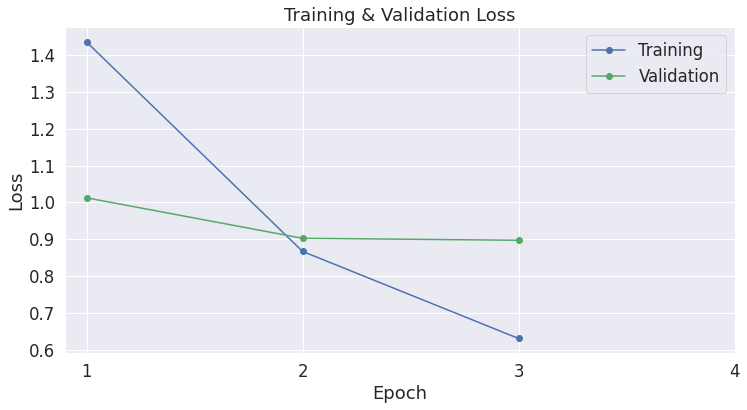

In [24]:
# Plotting Training and Validation loss

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Evaluation on Test Set

In [25]:
# Predictions on test set

print("Predicting labels ...")

# Putting model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(input_ids=b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.extend(logits)
  true_labels.extend(label_ids)

print(f"Predicted {len(predictions)} samples")

Predicting labels ...
Predicted 764 samples


In [26]:
# Final test accuracy and MCC

predictions = np.argmax(predictions, axis=1)
print(f"Test set accuracy: {accuracy_score(true_labels, predictions)}")
print(f"Test set Matthews correlation coefficient: {matthews_corrcoef(true_labels, predictions)}")

Test set accuracy: 0.6518324607329843
Test set Matthews correlation coefficient: 0.5942474930112771


## Save model to disk

In [27]:
# Saving the model

output_dir = f"./{model_name}/"

# For output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

model_to_save = model.module if hasattr(model, 'module') else model  
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./bert-base-uncased/


('./bert-base-uncased/tokenizer_config.json',
 './bert-base-uncased/special_tokens_map.json',
 './bert-base-uncased/vocab.txt',
 './bert-base-uncased/added_tokens.json',
 './bert-base-uncased/tokenizer.json')

In [28]:
# Mount Google Drive to this Notebook instance.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Copying the model files to Drive.
target_dir = f"\"./drive/My Drive/Teams_Lab\""
!cp -r $output_dir $target_dir

## Load Model from Drive

In [30]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
output_dir = f"./drive/My Drive/Teams_Lab/{model_name}/"

# Loading fine-tuned trained model and vocabulary
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

model.to(device)

Mounted at /content/drive


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Predict on some sample text

### Prediction

In [31]:
# Predicting an instance

texts = ["My friends surprised me on my birthday and I can't explain my happiness."]

In [32]:
input_ids = []
attention_masks = []

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                          text,            
                          add_special_tokens = True,
                          max_length = 64,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt')
  
  input_ids.append(encoded_dict['input_ids'])

  attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [33]:
model.eval()

predictions = []
last_layer_attentions = []

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

for i in range(len(input_ids)):

  ids = input_ids[i].unsqueeze(0)
  masks = attention_masks[i].unsqueeze(0)

  with torch.no_grad():
      outputs = model(input_ids=ids,
                      attention_mask=masks)

  logits = outputs[0]
  logits = torch.softmax(logits,dim=1)
  last_layer_attention = outputs[1][-1]
  
  logits = logits.detach().cpu().numpy()
  last_layer_attention = last_layer_attention.detach().cpu().numpy()

  last_layer_attentions.append(last_layer_attention)
  predictions.append(logits)

In [34]:
probs = predictions[0][0]
print("text:", texts[0])
print("predictions:", probs)
pred_idx = np.argmax(probs)
print(f"Prediction: {label_names[pred_idx]} ({probs[pred_idx]:.2f})", )

text: My friends surprised me on my birthday and I can't explain my happiness.
predictions: [0.00387967 0.00368916 0.00324323 0.00658866 0.9488748  0.00780295
 0.02592142]
Prediction: joy (0.95)


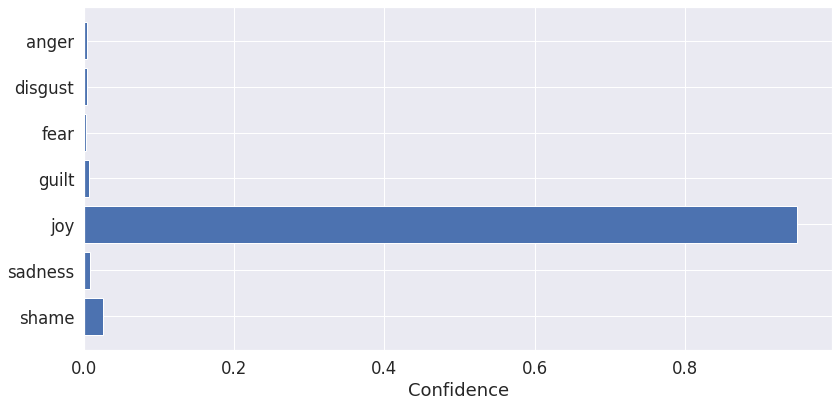

In [35]:
# Plotting confidence over all the emotions

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

y_pos = np.arange(len(label_names))
confidences = [probs[i] for i in range(len(label_names))]

ax.barh(y_pos, confidences, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Confidence')

fig.show()